In [1]:
import Pkg; Pkg.add(["Plots", "Interact", "Polyhedra", "GLPK"]);
import Logging; Logging.disable_logging(Logging.Info)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Project.toml`
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Manifest.toml`


LogLevel(1)

In [2]:
const STATIC_LECTURE = true;

In [3]:
function draw(plt)
    if STATIC_LECTURE
        filename = Base.Filesystem.tempname() * ".png"
        savefig(filename)
        return display("image/png", read(filename))
    else
        return plt
    end
end

draw (generic function with 1 method)

In [4]:
using LinearAlgebra;
using Plots; plotlyjs(); default(l=5, size=(900,550), label=false);
using Interact;
using Polyhedra;
using Printf;

import GLPK
lib = DefaultLibrary{Float64}(GLPK.Optimizer)

prettyprint(a) = map(x -> @sprintf("%+.2f", x), v)

function imshow(x; kwargs...)
    return heatmap(x
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=:diverging_gwv_55_95_c39_n256
        ; kwargs...
    )
end

WebIO._IJuliaInit()

imshow (generic function with 1 method)

**(Follow along: <https://tinyurl.com/gtcse6643lec8>)**

# Parallelism, Least Squares Problems

**1. Parallelism and QR**

**2. Least Squares Problems**

**3. Orthogonal Projection and the Normal Equations**

**4. The Pseudoinverse**

**5. Solving the Least Squares Problem**

## Parallelism and QR

### A summary comparison of algorithms

| algorithm | acts on | stability | behavior | cost |
| :-: | :-: | :-: | :-: | :-: |
| classical Gram-Schmidt | $$Q$$ | ❌ | left-looking | $$\sim 2mn^2$$ |
| modified Gram-Schmidt | $$Q$$ | ⚠️ | right-looking | $$\sim 2mn^2$$ |
| Householder QR | $$R$$ | ✅ | down-looking | $$\sim 2mn^2 - \textstyle{\frac{2}{3}}n^3$$ |

### The missing column(s)?

| algorithm | acts on | stability | behavior | cost | **_parallelism_** |
| :-: | :-: | :-: | :-: | :-: | :-: |
| classical Gram-Schmidt | $$Q$$ | ❌ | left-looking | $$\sim 2mn^2$$ | **?** |
| modified Gram-Schmidt | $$Q$$ | ⚠️ | right-looking | $$\sim 2mn^2$$ | **?** |
| Householder QR | $$R$$ | ✅ | down-looking | $$\sim 2mn^2 - \textstyle{\frac{2}{3}}n^3$$ | **?** |

### The importance of parallelism

- Most of the performance of modern computers is tied up in their ability to do multiple things **in parallel**
- The work (flops) is sometimes overshadowed by the cost of **moving data (communicating)** between the parallel parts of the machine

### Concurrency

- Roughly speaking, the **concurrency** of an algorithm is how much it exploits the paralleism of a computer:

  - High concurrency $\Rightarrow$ adding parallelism will make the implementation faster
  
  - Low concurrency $\Rightarrow$ adding parallelism does not speed up the calculation

### A simple model of parallelism for today: factoring lots of distributed data

$$
\begin{aligned}
&\begin{bmatrix} \hline
\\
A_1 \\
\\ \hline
\end{bmatrix}
&&\begin{bmatrix} \hline
\\
Q_1 \\
\\ \hline
\end{bmatrix}
\begin{bmatrix}\hline \strut R \\ \hline
\end{bmatrix}
\\
&\begin{bmatrix} \hline
\\
A_2 \\
\\ \hline
\end{bmatrix}
&&\begin{bmatrix} \hline
\\
Q_2 \\
\\ \hline
\end{bmatrix}
\begin{bmatrix}\hline \strut R \\ \hline
\end{bmatrix}\\
&\quad \vdots \quad \quad \quad=& &\quad \vdots\\
&\begin{bmatrix} \hline
\\
A_p \\
\\ \hline
\end{bmatrix}
&&\begin{bmatrix} \hline
\\
Q_p \\
\\ \hline
\end{bmatrix}
\begin{bmatrix}\hline \strut R \\ \hline
\end{bmatrix}
\end{aligned}
$$

- $m \gg n$, so each _processor_ has a portion of each column of $A$ and $Q$

- Copies of $R$ are small and can be duplicated for each processor

- We want to count **rounds of communication**: one round of communication for each matrix matrix product $A B$ where _both_ $A$ and $B$ have an $m$ dimension:

  - $Q \cdot R$, $Q \in \mathbb{C}^{m\times n}$, $R \in \mathbb{C}^{n\times n}$: 0 rounds
  
  - $Q^* Q$, $Q \in \mathbb{C}^{m \times n}$: 1 round
  
  - $Q y$, $Q \in \mathbb{C}^{m \times n}$, $y \in \mathbb{C}^n$: 0 rounds
  - $v^*w$, $v, w \in \mathbb{C}^m$: 1 round

### Rounds of communication in CGS / MGS?

In [5]:
function cgs(A)
    m, n = size(A); Q = copy(A); R = zeros(n, n);
    for j = 1:n
        R[1:j-1,j] = Q[:,1:j-1]' * Q[:,j] # 1
        Q[:,j] -= Q[:,1:j-1] * R[1:j-1,j] # 0
        R[j,j] = norm(Q[:,j])             # 1
        Q[:,j] /= R[j,j]                  # 0
    end
    return Q, R
end;

In [6]:
function mgs(A)
    m, n = size(A); Q = copy(A); R = zeros(n, n);
    for i = 1:n
        R[i,i] = norm(Q[:,i])             # 1
        Q[:,i] /= R[i,i]                  # 0
        R[i,i+1:n] = Q[:,i]' * Q[:,i+1:n] # 1
        Q[:,j] -= Q[:,[i]] * R[[i],i+1:n] # 0
    end
    return Q, R
end;

- Each of classical and modified Gram-Schmidt has two round of communication per iteration

$$\Rightarrow 2n \text{ rounds of communication}$$

### Rounds of communication in Householder?

(products subvectors of $m$-vectors will incur a round of communication, even if the length is $m - (i-1) < m$.

In [7]:
function householder_vector(x)
    u = copy(x)
    xnorm_tail = norm(x[2:end])           # 1 (broadcast x[1] in the same communication)
    phi = sign(u[1])                      # 0
    u[1] += phi * xnorm                   # 0
    unorm = (xnorm_tail^2 + u[1]^2)^(1/2) # 0
    u /= unorm                            # 0
    return u
end;

In [8]:
function householder_reflect(u,v)
    return v - 2*u*(u'*v) # 1
end

householder_reflect (generic function with 1 method)

In [9]:
function householder_reflect_left(vstar,u)
    return vstar - 2*(vstar*u)*u' # 1
end

householder_reflect_left (generic function with 1 method)

In [10]:
function householder_qr(A)
    m, n = size(A)
    U = zeros(eltype(A), m, n)
    R = copy(A)
    for i = 1:n
        U[i:m,i] = householder_vector(R[i:m,i])                # 1
        R[i:m,i:n] = householder_reflect(U[i:m,i], R[i:m,i:n]) # 1
        R[i+1:m,i] .= 0
    end
    return U, R
end

householder_qr (generic function with 1 method)

$$\Rightarrow 2n \text{ rounds of communication}$$

| algorithm | acts on | stability | behavior | cost | comm. rounds |
| :-: | :-: | :-: | :-: | :-: | :-: |
| classical Gram-Schmidt | $$Q$$ | ❌ | left-looking | $$\sim 2mn^2$$ | $$2n$$ |
| modified Gram-Schmidt | $$Q$$ | ⚠️ | right-looking | $$\sim 2mn^2$$ | $$2n$$ |
| Householder QR | $$R$$ | ✅ | down-looking | $$\sim 2mn^2 - \textstyle{\frac{2}{3}}n^3$$ | $$2n$$ |

### Online variant

How much communication is required if a new vector $v$ must be orthogonalized after the others have already been orthogonalized?

$$
\begin{aligned}
&\begin{bmatrix} \hline
& & \\
& Q_1 & \\
\\ \hline
\end{bmatrix}
\begin{bmatrix}\hline \strut R \\ \hline
\end{bmatrix},
\begin{bmatrix} \hline
\\
v_{1}\\
\\ \hline
\end{bmatrix}
\\
&\begin{bmatrix} \hline
& & \\
& Q_2 & \\
& & \\ \hline
\end{bmatrix}
\begin{bmatrix}\hline \strut R \\ \hline
\end{bmatrix},\begin{bmatrix} \hline
\\
v_{2}\\
\\ \hline
\end{bmatrix}\\
&\quad \vdots\\
&\begin{bmatrix} \hline
& & \\
& Q_p &  \\
& & \\ \hline
\end{bmatrix}
\begin{bmatrix}\hline \strut R \\ \hline
\end{bmatrix},\begin{bmatrix} \hline
\\
v_{p}\\
\\ \hline
\end{bmatrix}
\end{aligned}
$$

$$
\begin{aligned}
&\left[\begin{array}{ccc|c} \hline
& & & \\
& Q_1 & & q_1 \\
& & & \\ \hline
\end{array}
\right]
\begin{bmatrix}\hline \strut \tilde{R} \\ \hline
\end{bmatrix}
\\
&\left[\begin{array}{ccc|c} \hline
& & & \\
& Q_p & & q_p \\
& & & \\ \hline
\end{array}
\right]
\begin{bmatrix}\hline \strut \tilde{R} \\ \hline
\end{bmatrix}\\
&\quad \vdots\\
&\left[\begin{array}{ccc|c} \hline
& & & \\
& Q_p & & q_p \\
& & & \\ \hline
\end{array}
\right]
\begin{bmatrix}\hline \strut \tilde{R} \\ \hline
\end{bmatrix}
\end{aligned}
$$

### Classical Gram-Schmidt vs. Modified Gram-Schmidt, online communication

In [11]:
function cgs_new_vec!(Q,R,v)
    # store the orthogonalization of v as the last
    # columns of Q and R
    R[1:end-1,end] = Q[:,1:end-1]' * v           # 1
    Q[:,end] = v - Q[:,1:end-1] * R[1:end-1,end] # 0
    R[end,end] = norm(Q[:,end])                  # 1
    Q[:,end] /= R[end,end]                       # 0
end

cgs_new_vec! (generic function with 1 method)

In [12]:
function mgs_new_vec!(Q,R,v)
    # store the orthogonalization of v as the last
    # columns of Q and R
    Q[:,end] = v
    for i = 1:size(Q)[2]-1
        R[i,end] = Q[:,i]' * Q[:,end] # 1
        Q[:,end] -= Q[:,i] * R[i,end] # 0
    end
    R[end,end] = norm(Q[:,end]) # 1
    Q[:,end] /= R[end,end]      # 0
end

mgs_new_vec! (generic function with 1 method)

- Classical Gram-Schmidt: 2 rounds of communication for column $k$ $\Rightarrow$ $2n$ total

- Modified Gram-Schmidt: $k$ rounds of communication for column $k$ $\Rightarrow$ $(1/2)n^2$ total

- Householder QR: $k$ rounds of communication for column $k$  $\Rightarrow$ $(1/2)n^2$ total

| algorithm | acts on | stability | behavior | cost | static comm. rounds | online comm. rounds |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| classical Gram-Schmidt | $$Q$$ | ❌ | left-looking | $$\sim 2mn^2$$ | $$2n$$ | $$2n$$ |
| modified Gram-Schmidt | $$Q$$ | ⚠️ | right-looking | $$\sim 2mn^2$$ | $$2n$$ | $$\sim\textstyle\frac{1}{2}n^2$$ |
| Householder QR | $$R$$ | ✅ | down-looking | $$\sim 2mn^2 - \textstyle{\frac{2}{3}}n^3$$ | $$2n$$ | $$\sim\textstyle\frac{1}{2}n^2$$ |

- Classical Gram-Schmidt is widely used in online parallel orthogonalization.  It's stability deficiencies can be overcome using the same idea as HW2, Problem 8.

### Tall Skinny QR <https://arxiv.org/abs/0806.2159>

Consider just 2 processors:

1. Each processor does a QR factorization on its portion of the columns of $A$:

   $$\begin{aligned}
   A_1 &= \tilde{Q}_1 \hat{R}_1, \\
   A_2 &= \tilde{Q}_2 \hat{R}_2. \\
   \end{aligned}$$
   
   These separate equations can be restated as one matrix equation,
   
   $$
   A = \begin{bmatrix} A_1 \\ \hline A_2 \end{bmatrix} = 
   \underbrace{\left[\begin{array}{c|c} \tilde{Q}_1 & \\ \hline & \tilde{Q}_2 \end{array}\right]}_{\text{orthonormal columns}} \begin{bmatrix} \hat{R}_1 \\ \hline \hat{R}_2 \end{bmatrix}.
   $$
   

2. The processors exchange $\hat{R}_1$ and $\hat{R}_2$ with each other (1 round of communiciation) and each does a duplicate QR factorization of the vertical stack:

   $$\begin{bmatrix} \hat{R}_1 \\ \hline \hat{R}_2 \end{bmatrix} = \tilde{U} \hat{R} = 
   \begin{bmatrix} \tilde{U}_1  \\ \hline \tilde{U}_2 \end{bmatrix} \hat{R}$$
   
3. Each process can form its portion of the columns of $\hat{Q}$:

   $$A = \begin{bmatrix} A_1 \\ \hline A_2 \end{bmatrix} = \left[\begin{array}{c|c} \tilde{Q}_1 & \\ \hline & \tilde{Q}_2 \end{array}\right] \begin{bmatrix} \hat{R}_1 \\ \hline \hat{R}_2 \end{bmatrix} =
   \left[\begin{array}{c|c} \tilde{Q}_1 & \\ \hline & \tilde{Q}_2 \end{array}\right]\begin{bmatrix} \tilde{U}_1  \\ \hline \tilde{U}_2 \end{bmatrix} \hat{R} =
   \begin{bmatrix} \tilde{Q}_1\tilde{U}_1  \\ \hline \tilde{Q}_2 \tilde{U}_2 \end{bmatrix} \hat{R}.$$

### Tall Skinny QR is recursive

We can generalize this idea to halve the number of processes in each iteration for a total of

$$\log p\text{ round of communication}$$

| algorithm | acts on | stability | behavior | cost | static comm. rounds | online comm. rounds |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| classical Gram-Schmidt | $$Q$$ | ❌ | left-looking | $$\sim 2mn^2$$ | $$2n$$ | $$2n$$ |
| modified Gram-Schmidt | $$Q$$ | ⚠️ | right-looking | $$\sim 2mn^2$$ | $$2n$$ | $$\sim\textstyle\frac{1}{2}n^2$$ |
| Householder QR | $$R$$ | ✅ | down-looking | $$\sim 2mn^2 - \textstyle{\frac{2}{3}}n^3$$ | $$2n$$ | $$\sim\textstyle\frac{1}{2}n^2$$ |
| Tall Skinny QR (TSQR) | $$R$$ | ✅ | recursive | $$\sim 2mn^2 + \textstyle{\frac{2}{3}}n^3 p \log p$$ | $$\log p$$ | $$-$$ |
| Cholesky QR | $$A^*A$$ | ❌ | Cholesky | $$\sim 2mn^2 + \textstyle{\frac{1}{3}}n^3p$$ | $$1$$ | $$n$$ |

- There are tradeoffs in stability, work, and parallelism: different situations call for different QRs

## Least Squares Problems

### The problem

The linear problem

$$A x= b, \quad x\in \mathbb{C}^n, b \in \mathbb{C}^m, m > n,$$

is _overdetermined:_ in the general case ($b \not \in \mathrm{range}(A)$), there is no solution.

### The residual

Restated: for a particular $x$, the _residual_ vector, 

$$r = b - A x \in \mathbb{C}^m,$$

is not zero if $b \not \in \mathrm{range}(A)$.

### Residual visualized

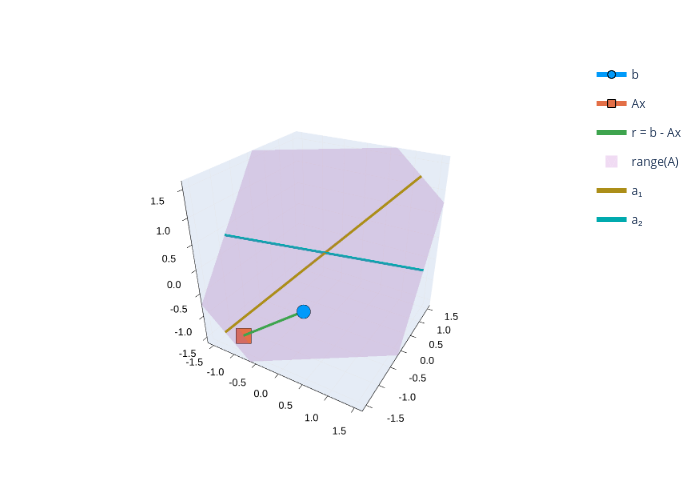

In [13]:
plotlyjs();
function plot_residual(A,x,b)
    corners = Float64[[-1,-1,-1] [ 1,-1,-1] [-1, 1,-1] [ 1, 1,-1] [-1,-1, 1] [ 1,-1, 1] [-1, 1, 1] [ 1, 1, 1]];
    cube = polyhedron(vrep(corners'), lib)
    triangle = [[2.0, 0.0] [-1.0, sqrt(3.)] [-1.0, -sqrt(3)]]*4
    Ax = A * x
    Q, R = qr(A, ColumnNorm())
    scale = maximum(abs.([b Ax]))
    if scale == 0
        scale = 1
    end
    scale *= 1.1
    p = plot(b[[1]], b[[2]], b[[3]]
        , m=:o
        , lim=(-scale, scale)
        , size=(1000,1000)
        , colorbar=:legend
        , label="b"
        , hover="b:<br>$(@sprintf("%+.2f", b[1]))<br>$(@sprintf("%+.2f", b[2]))<br>$(@sprintf("%+.2f", b[3]))"
    )
    plot!(p,Ax[[1]], Ax[[2]], Ax[[3]]
        , m=:square
        , label="Ax"
        , hover="x:<br>$(@sprintf("%+.2f", x[1]))<br>$(@sprintf("%+.2f", x[2]))<br>Ax:<br>$(@sprintf("%+.2f", Ax[1]))<br>$(@sprintf("%+.2f", Ax[2]))<br>$(@sprintf("%+.2f", Ax[3]))"
    )
    plot!(p,[Ax[1],b[1]],[Ax[2],b[2]],[Ax[3],b[3]]
        , label="r = b - Ax"
        , hover="r:<br>$(@sprintf("%+.2f", b[1] - Ax[1]))<br>$(@sprintf("%+.2f", b[2] - Ax[2]))<br>$(@sprintf("%+.2f", b[3] - Ax[3]))"
        )
    if (abs(R[1,1]) != 0.0)
        if abs(R[2,2]) > eps() * 100. * abs(R[1,1])
            # plot plane 
            Qtrivert = Q[:,1:2]*triangle
            Qtri = polyhedron(vrep((Q[:,1:2]*triangle)'), lib)
            isect = hcat(points(vrep(intersect(cube, Qtri)))...)*scale
            plot!(p,isect[1,:],isect[2,:],isect[3,:],st=:mesh3d
                , l = 0
                , fillalpha=0.5
                , label="range(A)"
                )
            q1 = A[:,1]
            q1max = maximum(abs.(q1))
            q1 *= scale / q1max
            plot!(p,[-q1[1], q1[1]],[-q1[2],q1[2]],[-q1[3],q1[3]]
                , label = "a₁"
                , hover="a₁:<br>$(@sprintf("%+.2f", A[1,1]))<br>$(@sprintf("%+.2f", A[2,1]))<br>$(@sprintf("%+.2f", A[3,1]))"
            )
            q2 = A[:,2]
            q2max = maximum(abs.(q2))
            q2 *= scale / q2max
            plot!(p,[-q2[1], q2[1]],[-q2[2],q2[2]],[-q2[3],q2[3]]
                , label = "a₂"
                , hover="a₂:<br>$(@sprintf("%+.2f", A[1,2]))<br>$(@sprintf("%+.2f", A[2,2]))<br>$(@sprintf("%+.2f", A[3,2]))"
            )
        else
            # plot line
            q = Q[:,1]
            qmax = maximum(abs.(q))
            q *= scale / qmax
            plot!(p,[-q[1], q[1]],[-q[2],q[2]],[-q[3],q[3]]
            )
        end
    end
    return p
end;
draw(plot_residual(randn(3,2), randn(2), randn(3)))

### Residual minimization

If $Ax = b$, we settle for the $x$ that makes the residual the smallest.

- "Smallest" implies a choice of norm.  As elsewhere, the Euclidean / 2-norm is our default choice.  The least squares problem:

$$\mathrm{minimize}_{x\in \mathbb{C}^n}\ \| Ax - b \|_2$$

- We more often see the equivalent minimization problem (hence the name _least squares_):

$$\mathrm{minimize}_{x \in \mathbb{C}^n}\ {\textstyle\frac 1 2} \| A x - b \|_2^2.$$

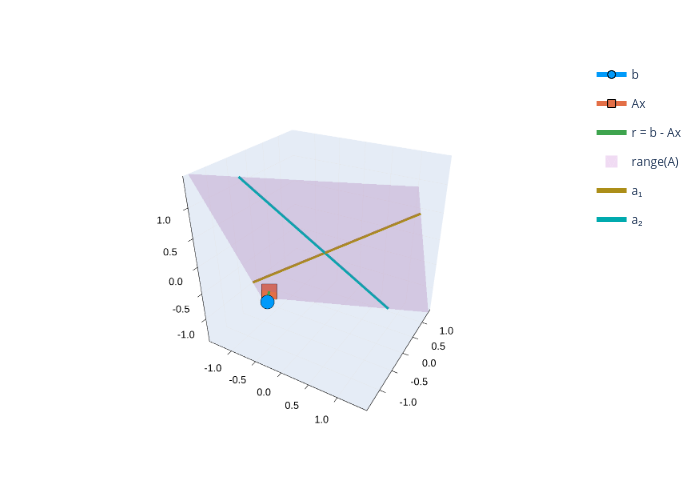

In [14]:
function plot_smallest_residual(A,b)
    corners = Float64[[-1,-1,-1] [ 1,-1,-1] [-1, 1,-1] [ 1, 1,-1] [-1,-1, 1] [ 1,-1, 1] [-1, 1, 1] [ 1, 1, 1]];
    cube = polyhedron(vrep(corners'), lib)
    triangle = [[2.0, 0.0] [-1.0, sqrt(3.)] [-1.0, -sqrt(3)]]*4
    x = A \ b
    Ax = A * x
    scale = maximum(abs.([b Ax]))
    if scale == 0
        scale = 1
    end
    scale *= 1.1
    p = plot(b[[1]], b[[2]], b[[3]]
        , m=:o
        , lim=(-scale, scale)
        , size=(1000,1000)
        , colorbar=:legend
        , label="b"
        , hover="b:<br>$(@sprintf("%+.2f", b[1]))<br>$(@sprintf("%+.2f", b[2]))<br>$(@sprintf("%+.2f", b[3]))"
    )
    plot!(p,Ax[[1]], Ax[[2]], Ax[[3]]
        , m=:square
        , label="Ax"
        , hover="x:<br>$(@sprintf("%+.2f", x[1]))<br>$(@sprintf("%+.2f", x[2]))<br>Ax:<br>$(@sprintf("%+.2f", Ax[1]))<br>$(@sprintf("%+.2f", Ax[2]))<br>$(@sprintf("%+.2f", Ax[3]))"
    )
    plot!(p,[Ax[1],b[1]],[Ax[2],b[2]],[Ax[3],b[3]]
        , label="r = b - Ax"
        , hover="r:<br>$(@sprintf("%+.2f", b[1] - Ax[1]))<br>$(@sprintf("%+.2f", b[2] - Ax[2]))<br>$(@sprintf("%+.2f", b[3] - Ax[3]))"
        )
    Q, R = qr(A, ColumnNorm())
    if (abs(R[1,1]) != 0.0)
        if abs(R[2,2]) > eps() * 100. * abs(R[1,1])
            # plot plane 
            Qtrivert = Q[:,1:2]*triangle
            Qtri = polyhedron(vrep((Q[:,1:2]*triangle)'), lib)
            isect = hcat(points(vrep(intersect(cube, Qtri)))...)*scale
            plot!(p,isect[1,:],isect[2,:],isect[3,:],st=:mesh3d
                , l = 0
                , fillalpha=0.5
                , label="range(A)"
                )
            q1 = A[:,1]
            q1max = maximum(abs.(q1))
            q1 *= scale / q1max
            plot!(p,[-q1[1], q1[1]],[-q1[2],q1[2]],[-q1[3],q1[3]]
                , label = "a₁"
                , hover="a₁:<br>$(@sprintf("%+.2f", A[1,1]))<br>$(@sprintf("%+.2f", A[2,1]))<br>$(@sprintf("%+.2f", A[3,1]))"
            )
            q2 = A[:,2]
            q2max = maximum(abs.(q2))
            q2 *= scale / q2max
            plot!(p,[-q2[1], q2[1]],[-q2[2],q2[2]],[-q2[3],q2[3]]
                , label = "a₂"
                , hover="a₂:<br>$(@sprintf("%+.2f", A[1,2]))<br>$(@sprintf("%+.2f", A[2,2]))<br>$(@sprintf("%+.2f", A[3,2]))"
            )
        else
            # plot line
            q = Q[:,1]
            qmax = maximum(abs.(q))
            q *= scale / qmax
            plot!(p,[-q[1], q[1]],[-q[2],q[2]],[-q[3],q[3]]
            )
        end
    end
    return p
end;
draw(plot_smallest_residual(randn(3,2), randn(3)))

### Example: polynomial interpolation (degree $n-1$ through $n$ points) can be a bad fit 

"||V||₂ ||V⁻¹||₂ = 1.6e+03"

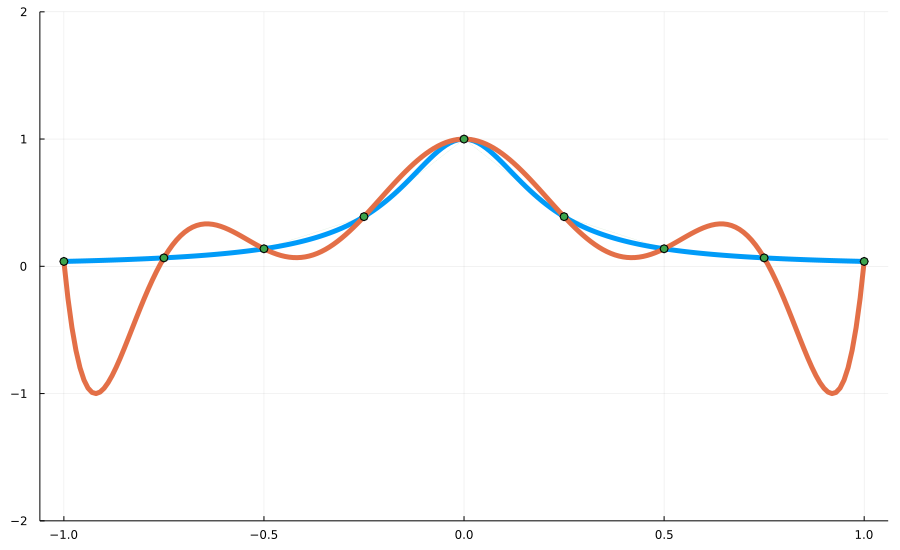

In [21]:
gr();
agnesi(x) = 1 ./ (1 .+ 25 * x .^ 2)
for n = 9
    p = n - 1
    x = LinRange(-1.0,1.0,p+1)
    y = agnesi(x)
    pows = 0:p
    V = hcat([ x .^ q for q in pows]...)
    c = V \ y
    xfull = LinRange(-1.0,1.0,200)
    yfull = map(x -> c' * (x .^ pows), xfull)
    txt = "||V||₂ ||V⁻¹||₂ = $(@sprintf("%.1e",cond(V)))"
    display(txt)
    p = plot(xfull, agnesi(xfull))
    plot!(p, xfull, yfull, ylim=(-2,2))
    plot!(p, x, y, l = 0, m = :o)
    draw(p)
    #vbox(txt, p)
end

Recall the Vandermonde matrix equation that solves for coefficients from interpolation values

$$
\underbrace{
\begin{bmatrix}
1 & x_1 & x_1^2 & & x_1^{n-1} \\
1 & x_2 & x_2^2 & \dots &x_2^{n-1} \\
1 & x_3 & x_3^2 & & x_3^{n-1} \\
  & \vdots & & & \vdots \\
1 & x_n & x_n^2 & & x_n^{n-1}
\end{bmatrix}
}_{V}
\begin{bmatrix}
c_0 \\ c_1 \\ c_2 \\ \vdots \\ c_{n-1}
\end{bmatrix}
=
\begin{bmatrix}
y_0 \\ y_1 \\ y_2 \\ \vdots \\ y_{n-1}
\end{bmatrix}
$$

### Polynomial least-squares (degree $n-1$ through $m>n$ points) is more stable

"||V||₂ ||V⁺||₂ = 5.3e+02"

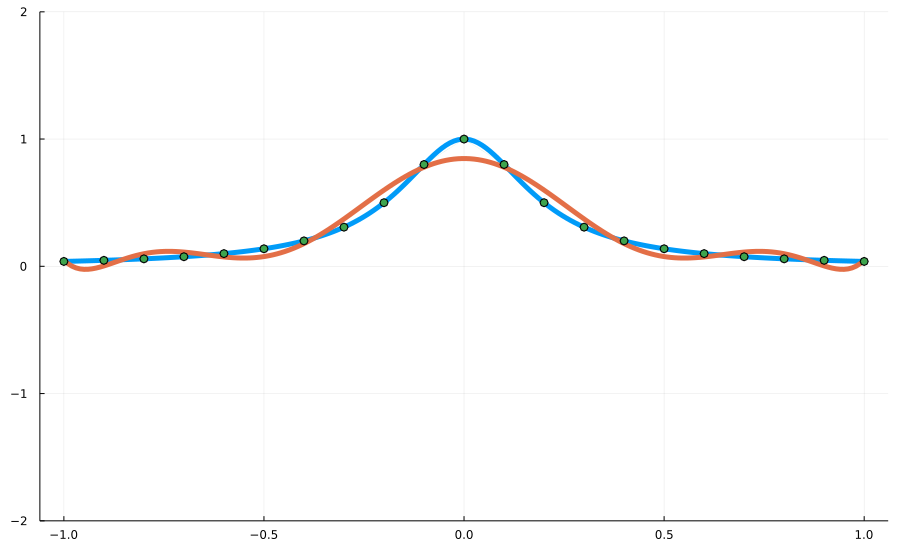

In [22]:
gr();
agnesi(x) = 1 ./ (1 .+ 25 * x .^ 2)
for n = 9, m = 21
    p = n - 1
    x = LinRange(-1.0,1.0,m)
    y = agnesi(x)
    pows = 0:p
    V = hcat([ x .^ q for q in pows]...)
    c = V \ y
    xfull = LinRange(-1.0,1.0,200)
    yfull = map(x -> c' * (x .^ pows), xfull)
    txt = "||V||₂ ||V⁺||₂ = $(@sprintf("%.1e",cond(V)))"
    display(txt)
    p = plot(xfull, agnesi(xfull))
    plot!(p, xfull, yfull, ylim=(-2,2))
    plot!(p, x, y, l = 0, m = :o)
    draw(p)
    #vbox(txt, p)
end

$$\mathrm{minimize}_{p \in \mathcal{P}^{n-1}}\ {\textstyle\frac 1 2} \sum_{i=1}^m |p(x_i) - y_i|^2$$

In terms of solving for the coefficients:

$$\mathrm{minimize}_{c \in \mathbb{C}^n}\ 
{\textstyle\frac 1 2} \| V c - y \|_2^2$$



### Least-squares over evenly spaced appoints approximately minimizes the $L^2$ inner product

If $\{x_i\}$ are evenly spaced throughout $[a, b]$, then (roughly speaking)

$$
\lim_{m \to \infty} \frac{1}{m} \sum_{i=1}^m |f(x_i) - g(x_i)|^2 = \| f - g \|_{L^2[a,b]}^2.
$$

Make the equivalent of $V$ for the given basis functions and solve for the coefficients as a least-squares problem.

## Orthogonal Projection and Normal Equations

### Go back and look at the first 3D residual plot

Your visual intuition is that $Ax$ can't be the closest to $b$ if $r$ is oblique to the plane of $\mathrm{range}(A)$.

Translated into math, the best choice of $x$ has

$$r \perp \mathrm{range}(A) \quad \Leftrightarrow \quad A^*r = 0.$$

**T&B Theorem 11.1.** Let $A \in \mathbb{C}^{m \times n}$ ($m \geq n$) and $b \in \mathbb{C}^m$ be given.

$$x = \arg\min_{\hat x} {\textstyle\frac 1 2}\|b - A\hat x\|_2^2 \quad \stackrel{i}{\Leftrightarrow} \quad A^*\underbrace{r}_{b - A x} = 0 \quad \stackrel{ii}{\Leftrightarrow} \quad \underbrace{A^*A x = A^*b}_{\text{normal equations}} \quad \stackrel{iii}{\Leftrightarrow} \quad \underbrace{Pb = Ax}_{P = \text{orth. proj. onto }\mathrm{range}(A)}$$

_Proof._ (just _i_, others follow from definitions).

_i._ ($\Rightarrow$) We can write $r = r_{\parallel} + r_{\perp},$ an orthogonal decompostion with $A^* r_{\perp} = 0$ and $r_{\parallel} = Ay \in \mathrm{range}(A)$:

$$
\|b - A(x + y)\|_2^2 = \|r - r_\parallel\|_2^2 = \|r\|_2^2 - \|r_\parallel\|_2^2.$$

By the assumption that $\|r\|_2$ is minimal $\|r_\parallel\|_2 = 0 \Rightarrow r_\parallel = 0.$

($\Leftarrow$) For every $z$ in $\mathbb{C}^n$,

$$\|b - Az \|_2^2 = \|r - A(x-z)\|_2^2 = \|r\|_2^2 + \|A(x-z)\|_2^2 \geq \|r\|_2^2.$$

### This equivalence is important

$$\underbrace{A^*A x = A^*b}_{\text{normal equations}} \quad \Leftrightarrow \quad \underbrace{Pb = Ax}_{P = \text{orth. proj. onto }\mathrm{range}(A)}$$

## The Pseudoinverse

### If we assume the normal equations are solvable

The matrix that maps $b \to x$ is the _pseudoinverse_ $A^+\in \mathbb{C}^{n \times m}$,

$$
x = \underbrace{(A^* A)^{-1} A^*}_{\text{pseudoinverse }A^+} b.
$$

### Recall a fact about projectors

Given $A$ full rank,

$$P = A (A^* A)^{-1} A^*$$

is the orthogonal projector onto $\mathrm{range}(A)$ (we did not have to construct an orthonormal basis of $\mathrm{range}(A)$ to build the projector).

But this is

$$P = A A^+.$$

### The pseudoinverse and the SVD

Let $\hat{U} \hat{\Sigma} V^*$ be the reduced SVD of $A$ (full rank, $\hat{\Sigma}$ invertible):

$$
\begin{aligned}A^+ &= (A^*A)^{-1} A^*
\\&= (V \hat{\Sigma}^* \hat{U}^* \hat{U}\hat{\Sigma} V^*)^{-1} V \hat\Sigma \hat U^*
\\&= (V \hat{\Sigma}^2 V^*)^{-1} V \hat\Sigma \hat{U}^*
\\&= V \hat{\Sigma}^{-2} V^* V \hat\Sigma \hat{U}^*
\\&= V \hat{\Sigma}^{-1} \hat{U}^*.
\end{aligned}
$$

### Exercise

**T&B Exercise 11.1.** Suppose the $m \times n$ matrix $A$ has the form

$$A = \begin{bmatrix} A_1 \\ A_2 \end{bmatrix},$$

where $A_1$ is a nonsingular matrix of dimension $n \times n$ and $A_2$ is an arbitrary matrix of dimension $(m-n) \times n$.  Prove that

$$\|A^+\|_2 \leq \|A_1^{-1}\|_2.$$

_Hint._

1. From the previous slide, every singular value of $A^+$ is the reciprocal of a singular value of $A$.
2. $\sigma_{\min}(A) = \min_{\|x\|_2 = 1} \|Ax\|_2$.
3. $\sigma_{\min}(A_1) = \min_{\|x\|_2 = 1} \|A_1 x\|_2.$

## Solving the Least Squares Problem

### Method 0: backslash

- Algorithm?
- Work?
- Stability?
- Parallelism?

In [17]:
m = 1000; n = 50;

A = randn(m, n); b = randn(m);

x_backslash = A \ b

orthogonality_error(A,x,b) = norm(A'*(b - A*x),2)
orthogonality_error(A, x_backslash, b)

2.100189853895953e-13

### Method 1: Cholesky factorization of $A^*A$ in normal equations

If $A$ is full rank, $A^*A$ has a Cholesky factorization, $A^*A = LL^*$, $L$ lower triangular and invertible.

1. Compute $A^*A$ (symmetry saves work, $\sim mn^2$)
2. Compute Cholesky factorization $LL^* = A^*A$, ($\sim \frac{1}{3}n^3$)
3. Compute $z = A^* b$ ($\sim 2mn$)
4. Solve $Lw = z$ ($\sim n^2$)
5. Solve $L^*x = w$ ($\sim n^2$)

Total work $\sim mn^2 + \frac{1}{3}n^3$.

In [18]:
K = A'*A
L = cholesky(K).L
z = A'*b
w = L \ z
x_cholesky = L' \ w

orthogonality_error(A, x_cholesky, b)

1.8185439587518324e-13

### Method 2: QR Factorization of $A$

1. Compute reduced QR factorization $A = \hat{Q}\hat{R}$ (most work efficient we've seen is Householder, $\sim 2mn^2 - \frac{2}{3}n^3$)
2. Compute $z = \hat Q^*b$ ($\sim 4mn - 2n^2$ with Householder reflectors)
3. Solve $\hat{R}x = z$ ($\sim n^2$)

Total work $\sim 2mn^2 - \frac{2}{3}n^3$

In [19]:
Q, R = qr(A)
z = (Q'*b)[1:n]
x_qr = R \ z
# note: norm((Q'*b)[n+1:m]) = ||r||_2

orthogonality_error(A, x_qr, b)

1.8815447184177143e-13

### Method 3: SVD of $A$

1. Compute the reduced SVD $A = \hat{U} \hat \Sigma V^*$ (approx $\sim 2mn^2 + 11n^3$)
2. Compute $z = \hat U^* b$ ($\sim 2mn$)
3. Solve $\hat \Sigma w = z$ ($\sim n$)
4. Compute $x = V w$ ($\sim 2n^2$)

Total work $\sim 2mn^2 + 11n^3$

In [20]:
U, σ, V = svd(A) # reduced by default
z = U'*b
w = z ./ σ
x_svd = V * w

orthogonality_error(A, x_svd, b)

4.972098334877801e-13

### Comparison

| algorithm | work | stability | parallelism |
| :-: | :-: | :-: | :-: |
| Cholesky | $$\sim mn^2 + {\textstyle\frac{1}{3}}n^3$$ | ❌? | best |
| QR | $$\sim 2mn^2 - {\textstyle\frac{2}{3}{n^3}}$$ | ✅? | good--better |
| SVD | $$\sim 2mn^2 + 11n^3$$ | ✅✅? | bad--good |

The next section of our class is making the stability of these algorithms _quantifiable_.